In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from scipy.spatial.transform import Rotation

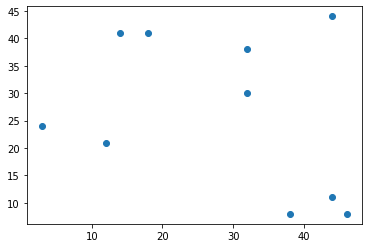

In [2]:
px = np.random.randint(0, 50, 11)
py = np.random.randint(0, 50, 11)

x, cx = px[:-1], px[-1]
y, cy = py[:-1], py[-1]

plt.scatter(x, y)
plt.show()

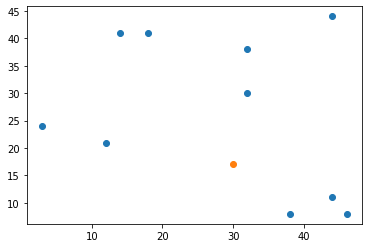

In [3]:
plt.scatter(x, y)
plt.scatter(cx, cy)
plt.show()

In [4]:
angle = 3
angle = np.radians(angle)
c, s = np.cos(angle), np.sin(angle)
R = np.array(((c, s), (-s, c)))
R

array([[ 0.99862953,  0.05233596],
       [-0.05233596,  0.99862953]])

In [5]:
points = np.stack([x, y], axis=0)
c = np.stack([cx, cy])[:, None]
print(points.shape, c.shape, (c - R @ c).shape)
rotated_points = R @ points + (c - R @ c)
rotated_points.shape

(2, 10) (2, 1) (2, 1)


(2, 10)

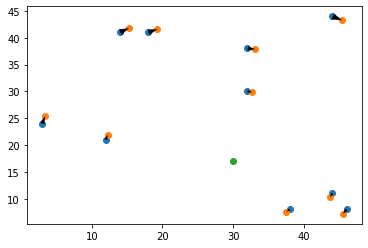

In [6]:
fig, ax = plt.subplots()
plt.scatter(points[0, :], points[1, :])
plt.scatter(rotated_points[0, :], rotated_points[1, :])
plt.scatter(cx, cy)
ax.quiver(
    points[0, :],
    points[1, :],
    rotated_points[0, :] - points[0, :],
    rotated_points[1, :] - points[1, :],
    angles='xy', scale_units='xy', scale=1
)
plt.show()

In [7]:
points.T

array([[38,  8],
       [ 3, 24],
       [32, 38],
       [12, 21],
       [18, 41],
       [44, 11],
       [32, 30],
       [44, 44],
       [14, 41],
       [46,  8]])

In [8]:
rotated_points.T

array([[37.51801267,  7.59364654],
       [ 3.40335426, 25.40347756],
       [33.09631415, 37.86654832],
       [12.2340122 , 21.93656535],
       [19.27250853, 41.59514031],
       [43.66679775, 10.2755194 ],
       [32.6776265 , 29.87751204],
       [45.39388431, 43.23029405],
       [15.27799039, 41.80448413],
       [45.50704895,  7.17495889]])

In [9]:
def generate_example(
    angle: float = 0,
    n: int = 10,
    verbose: bool = False,
    noise_mu: float = 1
):
    
    px = np.random.randint(0, 50, n + 1)
    py = np.random.randint(0, 50, n + 1)

    x, cx = px[:-1], px[-1]
    y, cy = py[:-1], py[-1]
    
    angle = np.radians(angle)
    c, s = np.cos(angle), np.sin(angle)
    R = np.array(((c, s), (-s, c)))

    points = np.stack([x, y], axis=0)
    c = np.stack([cx, cy])[:, None]
    rotated_points = R @ points + (c - R @ c)
    rotated_points_with_noise = rotated_points + np.random.normal(
        noise_mu, 1, np.product(rotated_points.shape)
    ).reshape(rotated_points.shape)
    
    if verbose:
        print(np.linalg.norm(rotated_points_with_noise - rotated_points))
        rotated_points = rotated_points_with_noise
        fig, ax = plt.subplots()
        plt.scatter(points[0, :], points[1, :])
        plt.scatter(rotated_points[0, :], rotated_points[1, :])
        ax.quiver(
                points[0, :],
                points[1, :],
                rotated_points[0, :] - points[0, :],
                rotated_points[1, :] - points[1, :],
                angles='xy', scale_units='xy', scale=1,
                width=0.005 / 4
        )
        plt.show()
    
    return points, rotated_points_with_noise

In [10]:
def get_prerot(points, rotated_points):
    norm_points = points.T - np.mean(points.T, axis=0)
    norm_rotated = rotated_points.T - np.mean(rotated_points.T, axis=0)

    norm_points /= np.mean(np.square(norm_points))
    norm_rotated /= np.mean(np.square(norm_rotated))

    x, projs = norm_points, norm_rotated
    angle_to_prerotate = np.arctan2(
        np.sum(projs[:, 0] * x[:, 1] - projs[:, 1] * x[:, 0]),
        np.sum(projs[:, 0] * x[:, 0] + projs[:, 1] * x[:, 1])
    )

    return np.rad2deg(angle_to_prerotate)


def _get_rot_angles(gt: np.array, proj: np.array, rots_to_estim: int = 10):
    centers = []
    indexes = []
    angles = []
    for _ in range(rots_to_estim):
        idcs = np.random.choice(len(gt), 2)
        indexes.append(idcs)

        gt1, proj1 = gt[idcs[0]], proj[idcs[0]]
        gt2, proj2 = gt[idcs[1]], proj[idcs[1]]

        c = _get_center_of_rotation(gt1, proj1, gt2, proj2)
        centers.append(c)
            
    mean_c = np.array([np.median([elm[0] for elm in centers]), np.median([elm[1] for elm in centers])])

    for i in range(rots_to_estim):
        idcs = indexes[i]

        gt1, proj1 = gt[idcs[0]], proj[idcs[0]]
        gt2, proj2 = gt[idcs[1]], proj[idcs[1]]

        angle = _get_rotation(gt1, proj1, gt2, proj2, mean_c)
        angles.append(angle)

    return centers, angles      

def _get_intersect(a1, a2, b1, b2):
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

def _get_norm_of_disp(gt, proj):
    vec = (proj - gt)
    return (-vec[1], vec[0])

def _get_center_of_rotation(gt1, proj1, gt2, proj2):
    n1, n2 = _get_norm_of_disp(gt1, proj1), _get_norm_of_disp(gt2, proj2)

    first_center = (gt1 + proj1) / 2
    second_center = (gt2 + proj2) / 2

    c = _get_intersect(
        first_center, first_center + n1,
        second_center, second_center + n2,
    )

    return c

def _get_rotation(gt1, proj1, gt2, proj2, c):
    cgt1, cproj1 = gt1 - c, proj1 - c
    cgt2, cproj2 = gt2 - c, proj2 - c

    res = Rotation.align_vectors(
        a=np.array([[*cgt1, 0], [*cgt2, 0]]),
        b=np.array([[*cproj1, 0], [*cproj2, 0]])
    )
    
    return res[0]

def get_prerot_2(points, rotated_points, estimate: int = 10):
    x, projs = points, rotated_points
    _, angles = _get_rot_angles(x.T, projs.T, rots_to_estim=estimate)
    
    deg_angles = [angle.as_euler("XYZ", degrees=True)[2] for angle in angles]
    counts = np.bincount([angle + 180.0 for angle in deg_angles])
    counts = np.convolve(counts, np.ones(3), 'same')
    angle_to_prerotate = np.argmax(counts) - 180
    
    return angle_to_prerotate

In [28]:
from skimage.measure import ransac

class PrerotModel:
    
    def estimate(self, data) -> bool: 
        # [N, 4]
        assert data.shape[1] == 4
        x, projs = data[:, :2], data[:, 2:]
        # print(x.shape, projs.shape, np.mean(x, axis=1))
        x -= np.mean(x, axis=0)[None, :]
        projs -= np.mean(projs, axis=0)[None, :]

        x /= np.mean(np.square(x))
        projs /= np.mean(np.square(projs))
        
        angle_to_prerotate = np.arctan2(
            np.sum(projs[:, 0] * x[:, 1] - projs[:, 1] * x[:, 0]),
            np.sum(projs[:, 0] * x[:, 0] + projs[:, 1] * x[:, 1])
        )
        
        self.params = angle_to_prerotate
        return True
    
    def residuals(self, data):
        # [N, 4]
        x, projs = data[:, :2], data[:, 2:]          
        norm_x = x.T - np.mean(x.T, axis=1)[:, None]
        norm_projs = projs.T - np.mean(projs.T, axis=1)[:, None]

        c, s = np.cos(self.params), np.sin(self.params)
        R = np.array(((c, s), (-s, c)))
        return np.linalg.norm(np.square(norm_x - R.T @ norm_projs), axis=0)

def get_prerot_3(
    points, rotated_points
) -> float:
    
    model, _ = ransac(
        np.concatenate([points, rotated_points]).T, 
        PrerotModel, 
        min_samples=5, 
        residual_threshold=3,
    )
    
    return np.rad2deg(model.params)

In [12]:
points, rotated_points = generate_example(10, n=100, noise_mu=0)
points = points.astype(np.float64)
get_prerot_3(points, rotated_points), get_prerot(points, rotated_points)

(100, 4)


(10.51218358742621, 10.638355264609542)

In [13]:
points.shape, rotated_points.shape

((2, 100), (2, 100))

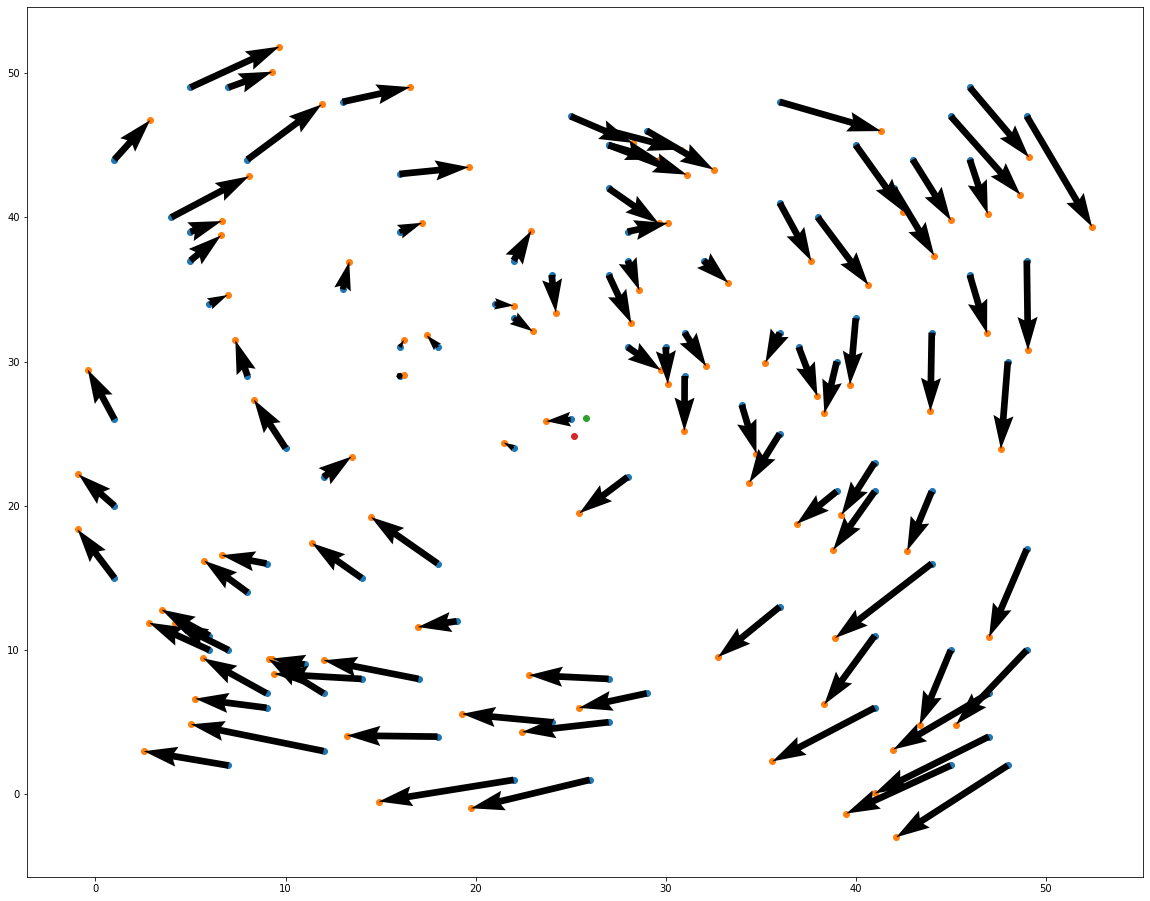

In [14]:
fig, ax = plt.subplots(figsize=(20, 16))
plt.scatter(points[0, :], points[1, :])
plt.scatter(rotated_points[0, :], rotated_points[1, :])
plt.scatter(*points.mean(axis=1))
plt.scatter(*rotated_points.mean(axis=1))
ax.quiver(
    points[0, :],
    points[1, :],
    rotated_points[0, :] - points[0, :],
    rotated_points[1, :] - points[1, :],
    angles='xy', scale_units='xy', scale=1
)
plt.show()

In [15]:
points -= np.mean(points, axis=1)[:, None]
rotated_points -= np.mean(rotated_points, axis=1)[:, None]

# points /= np.mean(np.square(points))
# rotated_points /= np.mean(np.square(rotated_points))

In [16]:
c, s = np.cos(np.deg2rad(10)), np.sin(np.deg2rad(10))
R = np.array(((c, s), (-s, c)))

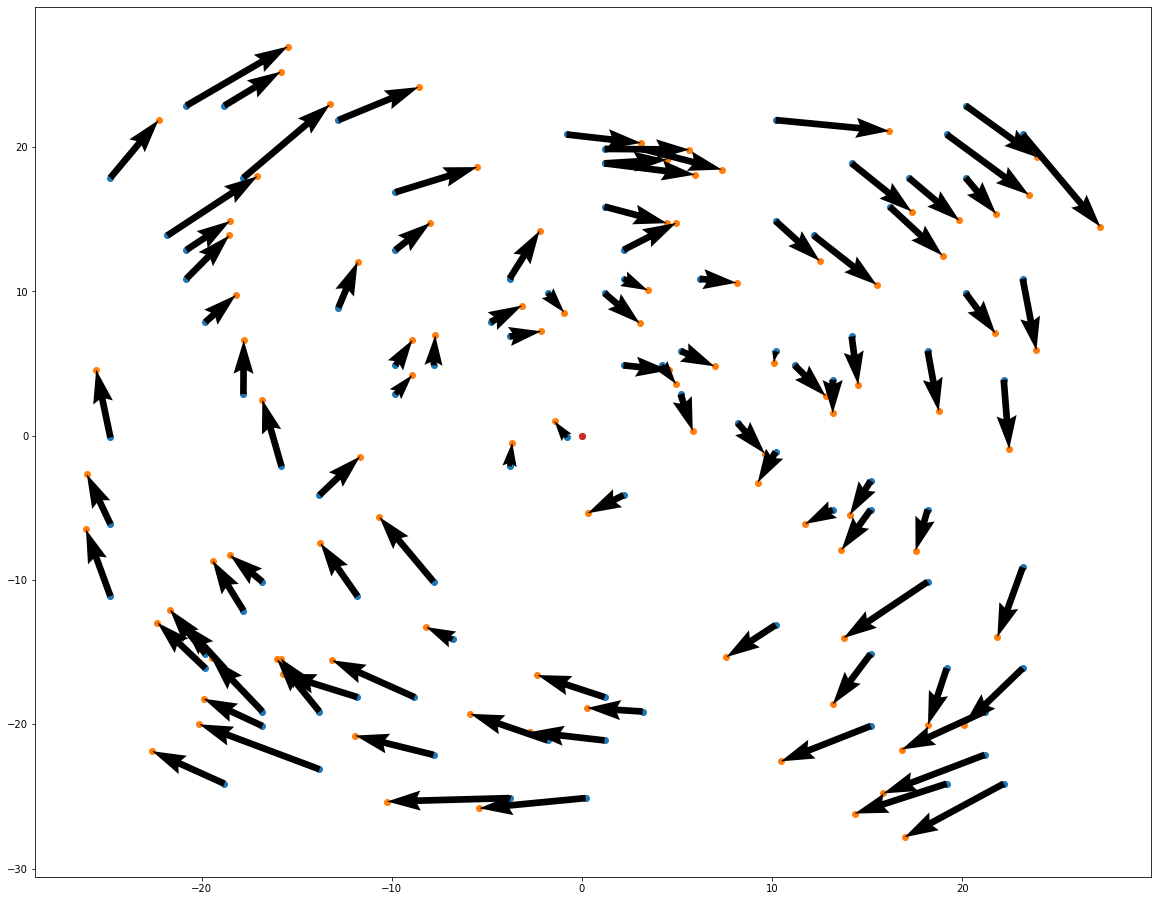

In [17]:
fig, ax = plt.subplots(figsize=(20, 16))
plt.scatter(points[0, :], points[1, :])
plt.scatter(rotated_points[0, :], rotated_points[1, :])
plt.scatter(*points.mean(axis=1))
plt.scatter(*rotated_points.mean(axis=1))
ax.quiver(
    points[0, :],
    points[1, :],
    rotated_points[0, :] - points[0, :],
    rotated_points[1, :] - points[1, :],
    angles='xy', scale_units='xy', scale=1
)
plt.show()

In [18]:
np.linalg.norm(points - rotated_points)

40.94525446912107

In [19]:
rotated_points = R.T @ rotated_points

In [20]:
np.linalg.norm(points - rotated_points)

13.566058071340025

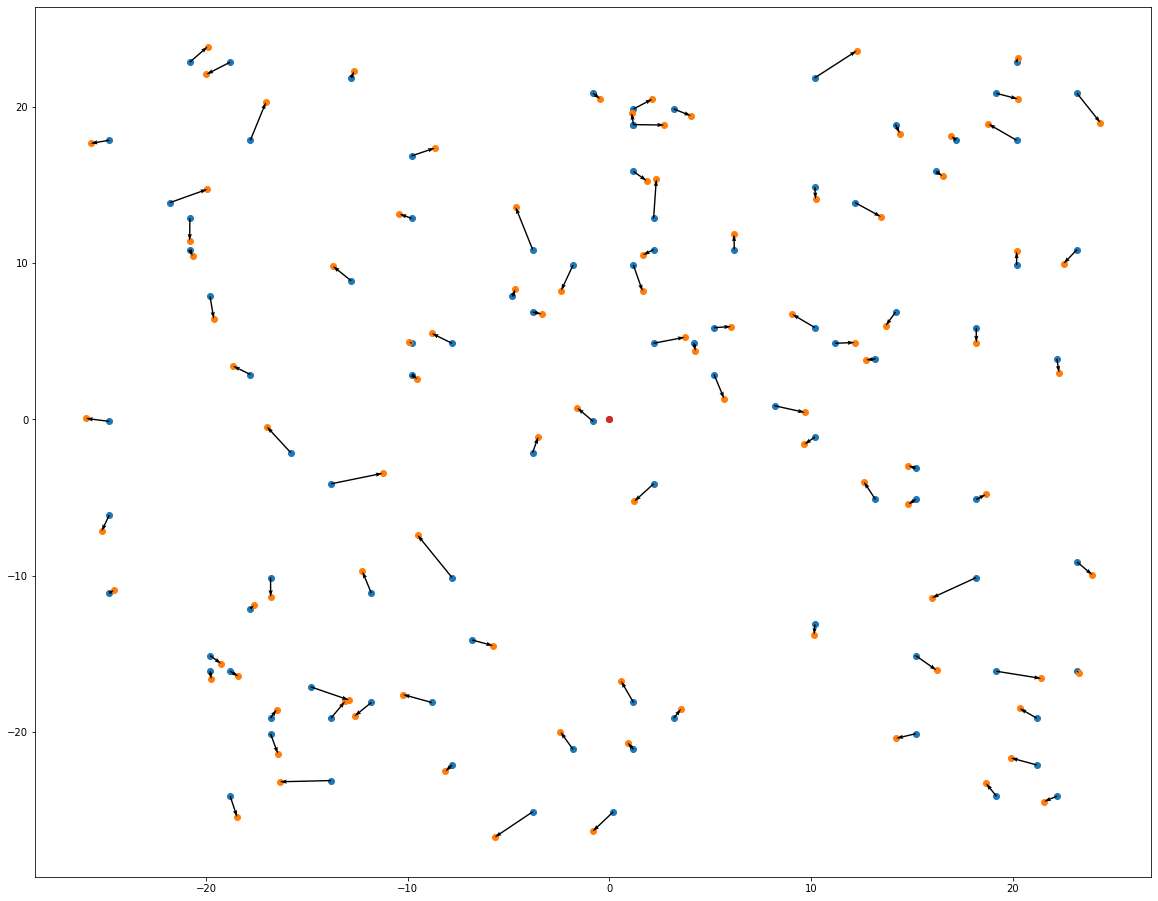

In [21]:
fig, ax = plt.subplots(figsize=(20, 16))
plt.scatter(points[0, :], points[1, :])
plt.scatter(rotated_points[0, :], rotated_points[1, :])
plt.scatter(*points.mean(axis=1))
plt.scatter(*rotated_points.mean(axis=1))
ax.quiver(
    points[0, :],
    points[1, :],
    rotated_points[0, :] - points[0, :],
    rotated_points[1, :] - points[1, :],
    angles='xy', scale_units='xy', scale=1,
    width=0.005/4
)
plt.show()

 28%|██▊       | 205/720 [00:00<00:00, 2049.53it/s]

58.98429156010083


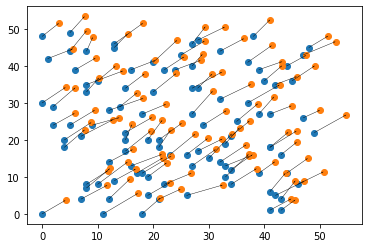

100%|██████████| 720/720 [00:00<00:00, 1333.86it/s]

0.557819128036499


(array([181.,   0.,   0.,   0., 199., 161.,   0.,   0.,   0., 179.]),
 array([-3.60748951e+02, -2.88593318e+02, -2.16437685e+02, -1.44282052e+02,
        -7.21264192e+01,  2.92136077e-02,  7.21848464e+01,  1.44340479e+02,
         2.16496112e+02,  2.88651745e+02,  3.60807378e+02]),
 <BarContainer object of 10 artists>)

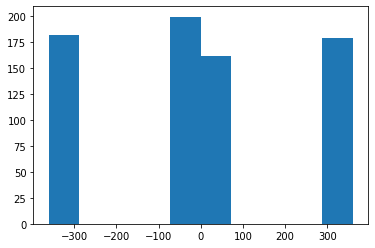

In [26]:
diffs = []
start_time = time.time()
for i in tqdm(range(-360, 360)):
    diffs.append(i - get_prerot(*generate_example(i, n=100, noise_mu=4, verbose=True if i == 0 else False)))
print(time.time() - start_time)

plt.hist(diffs,
         # range=[-10, 10]
        )

 50%|████▉     | 359/720 [00:27<00:13, 26.38it/s]

57.11473850395188


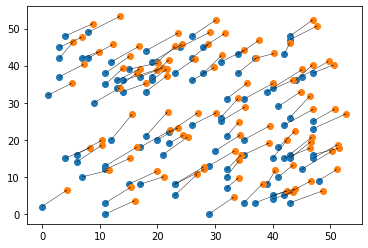

100%|██████████| 720/720 [00:44<00:00, 16.22it/s]

44.40829610824585


(array([181.,   0.,   0.,   0., 174., 185.,   0.,   0.,   0., 180.]),
 array([-3.61192714e+02, -2.88958245e+02, -2.16723777e+02, -1.44489308e+02,
        -7.22548396e+01, -2.03710813e-02,  7.22140974e+01,  1.44448566e+02,
         2.16683034e+02,  2.88917503e+02,  3.61151971e+02]),
 <BarContainer object of 10 artists>)

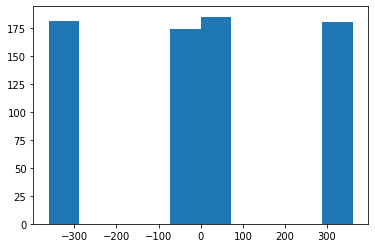

In [31]:
diffs = []
start_time = time.time()
for i in tqdm(range(-360, 360)):
    diffs.append(i - get_prerot_3(*generate_example(i, n=100, noise_mu=4, verbose=True if i == 0 else False)))
print(time.time() - start_time)

plt.hist(diffs,
         # range=[-10, 10]
        )

  6%|▌         | 20/360 [00:00<00:01, 198.40it/s]

20.34774312573908
19.59347293929353
19.849203451051125
19.938526344103444
18.65037301530884
20.210096329089996
19.28830013767072
20.554568462402642
20.63106030345395
19.429621829086972
20.237009774473965
19.813090701328907
19.48871845222862
20.15921877503186
21.450341383868366
19.20995409252517
20.712369674058916
21.637882786793238
20.631639467982723
20.62581833936263
20.42377054110904
18.791500190102845
19.759022303249996
19.81460318915363
19.02433999509
19.131510488750607
20.14853519895588
21.00955653868723
20.1334690635465
19.743763981450822
19.57912522452763
20.1961153408374
18.660632498921647
20.37311607579753
19.039229152888325
19.563101303558206
20.08495302266469
19.055174663307984
21.394262136516915

 11%|█         | 40/360 [00:00<00:01, 179.19it/s]<ipython-input-21-49222148bef4>:74: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  res = Rotation.align_vectors(
 16%|█▋        | 59/360 [00:00<00:01, 160.00it/s]


20.46978623735113
19.0489351749355
19.62718656348563
18.064358941039814
20.702949422481883
18.567482532573344
20.966464491396728
20.44564088775305
21.38736182939256
19.701454914887393
20.484396205323215
20.69826702303073
19.098061978957055
20.687388165906906
20.073795648385467
20.063995074576457
18.146235446964432
21.460720813095637
20.895970237119155
20.410685861526854
20.03015407545597
20.147028070906362
21.03631856050154
19.25450597622488
20.26851794879535
19.794089853726362
21.201171212546285
19.152660813413195
19.450672791870627
19.81182281909246
19.561219061036894


 26%|██▌       | 93/360 [00:00<00:01, 147.03it/s]

21.19599474049598
21.507321307992257
21.139134531780954
21.484907777775735
21.07012873116275
21.819578767670304
18.192506791320113
18.4574204962054
18.81821831370564
18.801624203639122
19.161894837040904
20.41780216710639
20.000208600373075
19.376218795466183
21.198811689373123
19.829905340912013
19.1710072007355
19.101349654274053
19.10868388298028
18.718503373625055
19.470241338450467
18.42004806894131
21.104811509410556
20.50675969357756
18.87968092862582
20.52117196508903

 30%|███       | 108/360 [00:00<00:02, 118.74it/s]


21.341233163676577
21.630265160733167
19.522900641960845
21.342228813556627
21.539354459589607
19.994055786019807
20.039009025744566
19.47517584778349
20.343360897847692
20.52273336044988
18.952142981317312
20.382572637679335
18.947159016589858
22.218614752111787
20.75469177591477
18.54771487725012
21.401658885430585
18.693297773154516
20.755546004405385
17.68346082287313
18.23040829383918
21.084491035285414
20.645379527822794
19.054900057761536
20.30673417061753


 37%|███▋      | 133/360 [00:01<00:02, 95.99it/s] 

20.262956148550167
21.243955045086235
20.372500948033096
19.167995103103127
20.25065495444697
19.536453841086647
18.721701668012148
21.058434496885337
21.80410307563426
20.27180272864827
18.714109572168905
20.83468624318647
20.228808016847626
18.64181355213799
21.985453977997537
20.833687159255483
20.60581314266816
19.112718967681946
20.27110291592107
20.94727295291652
18.63024444776086
20.48510957073062
19.846580233027165
18.62266153385052
19.146792557116534
21.650644867177366
20.002187709279603


 43%|████▎     | 156/360 [00:01<00:01, 126.10it/s]

18.513098574203642
20.228084934434957
20.745948265158948
19.70597960932114
19.61842464809893
22.089771543933395
20.575685013364588
19.541238370639547
20.626199681606366
19.1754583857284
20.294505274498245
19.82679487921925
19.472814210739777
18.891918374956163
19.874606500339272
20.717537775326505
18.04902003210394
20.9082766555052
20.49037171688851
20.27769902873387
20.542738743579996

 51%|█████     | 183/360 [00:01<00:01, 110.14it/s]


20.680657978111125
19.195488690731494
19.511296879236994
20.67737087858267
19.74271171265457
20.744016887273524
20.165223530841935
18.614088020327355
20.994869767394327
19.7713740070466
19.297770533903595
20.121042931384093
20.884130043470083
18.046265702990368
19.744262812728937
19.943713427449133
20.055614729930635
20.45110839061107
20.8387001171586
19.131841202423455
18.56626362704181
21.146148167267125
20.757224606777758
19.174911178801008
21.08894279983435

 59%|█████▉    | 212/360 [00:01<00:01, 124.15it/s]


20.24463852069749
19.8391187448556
19.465833766706098
21.89110871439536
20.292072606862796
19.438716541014138
18.904497241725252
20.59020415182067
19.763095203019855
20.803832377336647
21.06696551110019
20.480111563449707
19.657809981132992
18.97863086312083
19.98442429410297
19.493412550644177
18.63288695655295
18.877339438842952
19.436112847710028
21.02809047112948
19.424872541283655
18.632555618762442
19.56350149054625
21.507723819914588
19.01220336583719
19.184357637848397
20.09163938070928
18.55480165465131
19.948029281539508
19.418521285410378
19.344205952104357
20.26691331862275
20.250889972043264
21.68399284241246
19.232785249095237
19.974316225678418
19.401803942855047
19.110197238546498
20.319809242150225
18.681444688816686
20.537983937030354
20.14762366716134
19.771819529680332


 71%|███████   | 254/360 [00:01<00:00, 133.56it/s]

19.035181063646025
20.6091527312966
20.039479539871436
19.79041793529587
20.121536736725453
19.74600772480586
18.85245160482036
21.77087686179988
19.883542609355665
19.440885613025113
19.946188895473473
19.943905958977012
19.412542112680708
20.103833501681503
18.598537582859237
20.222743018450153
20.14669566522783
18.352324748745154
19.336070112105148
20.691458230025674
20.301316407925256
19.919313217443037

 75%|███████▍  | 269/360 [00:02<00:00, 130.27it/s]


21.04139510462947
20.22294328533229
21.79482362428168
20.882156206514487
20.053723469407252
19.206036465657313
19.99370885677
19.452363679637344
20.207609917232993
20.816793530116367
20.046557942764405
19.428068014658393
21.0874178916475
19.547516498730218
21.021033874197403
18.89145142352437
20.309497864274565
20.177746791441468
21.779587447838097

 85%|████████▌ | 306/360 [00:02<00:00, 132.02it/s]


18.68643169863029
19.813819531634632
19.598868668324386
18.52052752395208
18.51239057174192
19.723767660946873
21.0493733975785
20.621716486133163
19.997309826316066
18.701358007110432
21.592350276213136
19.526232324369307
20.06889476583598
19.253983090624168
18.78456382966003
20.389942208745786
20.752231851348384
20.48952178758679
19.643553208123432
19.576581815555883
21.129651290066494
20.209689828989813
21.068989696903916
18.926296428092968
19.422328644595407
17.79882911139445
19.702247652667662
19.838281578831737
19.394034365951587
20.9665155700612
19.89946496866686
20.767448373177064
19.638538387939068
19.488755470432352
19.920924853808604
20.457339434066455
20.047423319584436


 93%|█████████▎| 336/360 [00:02<00:00, 121.72it/s]

19.034299512110735
19.305098239869476
19.48655597166007
18.762104605444765
18.89982472279648
19.893020921237444
20.56227154786163
21.370737202053416
19.401567822625204
19.784765480115375
18.851899542794403
19.387603238504596
19.188312630915323
20.76697522726239
19.019642953089022
21.536151642571625
19.316752979675073
21.104560453171757
20.56435419195631
19.400745968557256
20.579463173532627
19.78993926522011
21.128819447805856
19.008168876188037


100%|██████████| 360/360 [00:02<00:00, 122.76it/s]

22.22197077500972
20.089855918849064
19.44342577690711
20.10202235526865
20.513462461579223
21.598585557929923
19.60070926753839
19.443815951908242
20.263534353003617
18.91817258204562
20.709929646746136
19.235663116663275
19.568632613579517
19.58337611218114
19.062464967194018
20.663511318743083
20.661938100170286
19.832905386935604
19.76604188772822
19.434111361589714
19.129425583470073
2.9410901069641113


(array([  1.,   1.,   5.,  22., 111., 136.,  61.,  14.,   2.,   4.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <BarContainer object of 10 artists>)

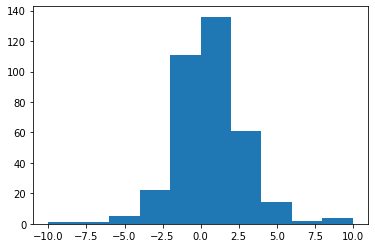

In [23]:
diffs = []
start_time = time.time()
for i in tqdm(range(-180, 180)):
    try:
        diffs.append(i - (get_prerot_2(*generate_example(i, n=100), estimate=5) + 1))
    except Exception as ex:
        print(ex)
        continue
print(time.time() - start_time)

plt.hist(diffs, range=[-10,10])